In [1]:
from numba import jit
import numpy as np
import time
from tools.utility import im_read, show_img

path_image_a = './test_images/a.png'
path_image_b = './test_images/b.png'

a = im_read(path_image_a)
b = im_read(path_image_b)
a=a/255.
b=b/255.

!ls ./test_images

a.png  b.png  synt_a.png  synt_b.png


In [5]:
np.random.seed(int((time.time()*1e6)%1e6))

# Approximating the nearest neighbour field by rarndom search in the
# offset space as described in
# http://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/patchmatch.pdf

# distance_function
@jit
def ssd(patch1, patch2):
    return np.sum((patch1-patch2)**2)

def corr_distance(patch1, patch2):
    1 - correlation_coefficient(patch1,patch2)

def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

# Calculate nnf:
# correspondece of patches of A in B
@jit
def nnf_approx(A,B,nnf=None,distance_function=ssd,patch_size=5,iterations=5):
    print("initilaization")
    nnf = initialization(A,B,distance_function,patch_size) if nnf is None else nnf
    print("initial reconstruction")
    for i in range(iterations):
        print("==========iteration {}/{} ==========".format(i+1,iterations))
        iteration(A,B,nnf,distance_function,patch_size,i%2==0)
    rec = reconstruction(A,B,nnf,patch_size)
    return rec,nnf

# Initialize nnf field from A to B
# the size of nnf must hold all coordinates for patches in A
# therefore for A patch_size and h,w = A.width, A.height given,
# the resulting nnf is of size h-(patch_size//2)*2, w-(patch_size//2)*2
#
#                             patch_size//2*2
#                                ____
#  _________________A________________
# ||                            |    |
# ||                            |    |
# ||                            |    |
# ||             nnf            |    |
# ||                            |    |
# ||                            |    |
# ||____________________________|    |
# |                                  |  | patch_size//2*2
# |__________________________________|  |
@jit
def initialization(A,B,distance_function,patch_size):
    h,w = A.shape[0:2]
    h_nnf = h-patch_size//2*2
    w_nnf = w-patch_size//2*2
    nnf = np.zeros((h_nnf,w_nnf,3))
    for i in range(h_nnf):
        for j in range(w_nnf):
            # initialize with random values and calculate distance
            nnf_i = np.random.randint(0,high=h_nnf)
            nnf_j = np.random.randint(0,high=w_nnf)
            nnf[i,j,0] = nnf_i
            nnf[i,j,1] = nnf_j
            nnf[i,j,2] = distance_function( A[i:i+patch_size, j:j+patch_size],
                            B[nnf_i:nnf_i+patch_size, nnf_j:nnf_j+patch_size])
    return nnf

@jit
def iteration(A,B,nnf,distance_function,patch_size,even,step=1):
    nnf_h,nnf_w = nnf.shape[0:2]
    total = (nnf_h)*(nnf_w)

    if even:
        # even iteration propagation: scan order (l-r,t-b)")
        inc_left_h,exc_right_h,d = step, nnf_h, 1
        inc_left_w,exc_right_w,d = step, nnf_w, 1
        for i in range( inc_left_h, exc_right_h, d ):
            for j in range( inc_left_w, exc_right_w, d ):
                propagation(i,j,A,B,nnf,distance_function,patch_size, -step if even else step)
                random_search(i,j,A,B,nnf,distance_function,patch_size)

    else:
        # odd iteration\npropagation: inverse scan order (t-b,r-l)"
        inc_left_h,exc_right_h,d = (nnf_h-1)-step,-1,-1
        inc_left_w,exc_right_w,d = (nnf_w-1)-step,-1,-1
        for j in range( inc_left_w, exc_right_w, d ):
            for i in range( inc_left_h, exc_right_h, d ):
                propagation(i,j,A,B,nnf,distance_function,patch_size, -step if even else step)
                random_search(i,j,A,B,nnf,distance_function,patch_size)

@jit
def propagation(i,j,A,B,nnf,distance_function,patch_size,propagation_offset_step):
    b_h, b_w = B.shape[0:2]

    # current offset
    min_i,min_j,min_dist = nnf[i,j]
    update = False

    # shifted offset on h
    fi,fj,curr_dist = nnf[i+propagation_offset_step,j]
    # update min
    if curr_dist < min_dist:
        if is_clamped( b_h, b_w, \
                    fi-propagation_offset_step, \
                    fi-propagation_offset_step + patch_size, \
                    fj, fj+patch_size ):
            min_i = fi-propagation_offset_step
            min_j = fj
        else:
            min_i = fi
            min_j = fj
        min_dist = curr_dist
        update = True

    # shifted offset on w
    fi,fj,curr_dist = nnf[i,j+propagation_offset_step]

    # update min
    if curr_dist < min_dist:
        if is_clamped( b_h, b_w, \
                fi, fi + patch_size, \
                fj-propagation_offset_step, \
                fj-propagation_offset_step+patch_size ):
            min_i = fi
            min_j = fj-propagation_offset_step
        else:
            min_i = fi
            min_j = fj
        min_dist = curr_dist
        update=True

    # update f(ij)
    nnf[i,j,0] = min_i
    nnf[i,j,1] = min_j
    if update:
        nnf[i,j,2] = distance_function(A[i:i+patch_size,j:j+patch_size], \
                            B[int(min_i):int(min_i)+patch_size, int(min_j):int(min_j)+patch_size])


#  how to clamp
# h0,w0_____________
#   |               |
#   | i0,j0_________|______
#   |   |           |      |
#   |   |    clamp  |      |
#   |   |           |      |
#   |   |           |      |
#   |___|___________|h1,w1 |
#       |                  |
#       |__________________| i1,j1
#
#@jit
def clamp(h0,h1,w0,w1,i0,i1,j0,j1):

    c_i0 = h0 if i0 < h0 else i0
    c_i0 = i0 if i0 < h1 else h-1

    c_i1 = h0 if i1 < h0 else i1
    c_i1 = i1 if i1 < h1 else h-1

    c_j0 = w0 if j0 < w0 else j0
    c_j0 = j0 if j0 < w1 else w1-1

    c_j1 = w0 if j1 < w0 else j1
    c_j1 = j1 if j1 < w1 else w1-1

    return c_i0,c_i1,c_j0,c_j1

@jit
def random_search(i,j,A,B,nnf,distance_function,patch_size):
    nnf_h,nnf_w = nnf.shape[0:2]
    a_h, a_w = A.shape[0:2]
    b_h, b_w = B.shape[0:2]
    w = max(nnf_h,nnf_w)
    v_i_0,v_j_0,curr_min_dist = nnf[i,j] # v0 is not updated (why? authorss)

    # searchin in exponentially decreasing area for A match
    while( w > 1 ):
        # Rix,Riy in -1/2,1/2
        Ri_t,Rj_t = np.random.rand()-1.0, np.random.rand()-1.0

        # offsets in -w/2,w/2
        u_i_t,u_j_t = int(v_i_0 + np.floor(w*Ri_t)), int(v_j_0 + np.floor(w*Rj_t))

        # Clamp to image borders
        if is_clamped( b_h, b_w, u_i_t, u_i_t+patch_size, u_j_t, u_j_t+patch_size ):

            # calculate new distance for random found patch
            new_distance = distance_function(A[i:i+patch_size, j:j+patch_size], \
                                             B[u_i_t:u_i_t+patch_size, u_j_t:u_j_t+patch_size])
            # update value
            if new_distance < curr_min_dist:
                curr_min_dist = new_distance
                nnf[i,j] =  u_i_t, u_j_t, new_distance

        # exponential decrease
        w //= 2

@jit
def is_clamped(h,w,i0,i1,j0,j1):
    p1 = i0 < h and i0 > 0
    p2 = i1 < h and i1 > 0
    p3 = j0 < w and j0 > 0
    p4 = j1 < w and j1 > 0
    return p1 and p2 and p3 and p4

@jit
def reconstruction(A,B,nnf,patch_size):
    reconsturcted = np.zeros(A.shape)
    weights = np.ones(A.shape)
    nnf_h,nnf_w = nnf.shape[0:2]
    a_h, a_w = A.shape[0:2]
    b_h, b_w = B.shape[0:2]
    for i in range( patch_size//2+1, nnf_h):
        for j in range( patch_size//2+1, nnf_w):
            nnf_i = nnf[i,j,0]
            nnf_j = nnf[i,j,1]
            for k in range(-patch_size//2,1):
                for l in range(-patch_size//2,1):
                    i1,j1 = i+k,j+l
                    nnf_i1,nnf_j1 = int(nnf_i)+l,int(nnf_j)+k
                    # check if the patch is in the area of B
                    if is_clamped( b_h, b_w, nnf_i1, nnf_i1+patch_size, nnf_j1, nnf_j1+patch_size ):
                        reconsturcted[i1:i1+patch_size, j1:j1+patch_size] += \
                            B[nnf_i1:nnf_i1+patch_size, nnf_j1:nnf_j1+patch_size]
                        weights[i1:i1+patch_size,j1:j1+patch_size] += 1.0
    return reconsturcted/weights


In [11]:
%%time
rec,nnf = nnf_approx(a,b,patch_size=2)

initilaization
initial reconstruction
==========iteration 1/5 ==========
==========iteration 2/5 ==========
==========iteration 3/5 ==========
==========iteration 4/5 ==========
==========iteration 5/5 ==========
CPU times: user 22.4 s, sys: 54.9 ms, total: 22.5 s
Wall time: 22.4 s


In [10]:
%%time
rec,nnf = nnf_approx(a,b)

initilaization
initial reconstruction
==========iteration 1/5 ==========
==========iteration 2/5 ==========
==========iteration 3/5 ==========
==========iteration 4/5 ==========
==========iteration 5/5 ==========
CPU times: user 24.7 s, sys: 233 ms, total: 25 s
Wall time: 24.7 s


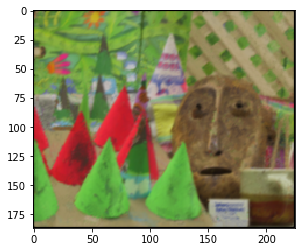

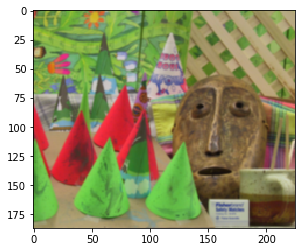

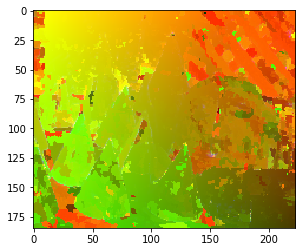

In [12]:
show_img(rec)
show_img(a)
show_img(nnf)